In [2]:
#!pip install numpy==1.19.5
import sys
sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
import Utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kerastuner
print(tf.__version__)
print(kerastuner.__version__)
print(np.__version__)


2.3.0
1.0.2
1.19.5


In [3]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))




In [4]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
    #    print(
    #        "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    #    )
        return

    def on_test_batch_end(self, batch, logs=None):
     #   print(
     #       "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
     #   )
        return

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and MSE is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_squared_logarithmic_error"]#logs["mean_squared_logarithmic_error"]
            )
        )


In [7]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/SFR/DATA/SFR_data_8.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=Utilities.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= Utilities.ProcessData(datapath, 1,1000,0,0,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data


Load Data loads raw data from the .mat file
Inputs
datapath: Path to .mat file containing the data [string]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

ProcessData is the serialization maker 
Inputs
datapath: Path to .mat file containing the data [string]
Percent of data to be used: in most cases full data set will be used but good for analysis [double](0-1)
ndecades: Number of decades wanted in equal lethargy serialization. Number is ignored if custom serialization inputted [int]
mode: equal lethargy mode (0) or custom serialization mode (1) [boolean]
input serial: a custom serialization regime (ignored if mode is not 1) [numpy array]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

In [10]:

#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)

(50000,)
50000
(50000, 3)


In [11]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = Utilities.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(50000, 3)
(3, 35000)


makeFractions splits the data into appropriatly sized sets
Nsamples is the number of samples of the data set
vldF is the validation fraction
testF is the test fraction
allData is the set of serialzed group structures
y_norm is the kinfs that correspond to the serialized group structures (normalized or otherwise)
BU (the last input) is a boolean determining whether the data contains burnup [Boolean] (used in the same manner as previous)

In [12]:

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (200, 0.0001),
    (400, 0.00001),
    (500, 0.000001),
    (600,0.0000001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [13]:
keff_model = tf.keras.Sequential([
    layers.Dense(70, activation='relu', name='hidden_1', input_dim=999),
    layers.Dense(717, activation='relu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
keff_model.compile(loss="mean_squared_logarithmic_error",optimizer=tf.keras.optimizers.Adam(1e-03),metrics="mean_squared_logarithmic_error")
keff_model.build()
keff_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 70)                70000     
_________________________________________________________________
hidden_2 (Dense)             (None, 717)               50907     
_________________________________________________________________
output (Dense)               (None, 3)                 2154      
Total params: 123,061
Trainable params: 123,061
Non-trainable params: 0
_________________________________________________________________


In [14]:
keff_model.fit(X_train,y_train.T, epochs=800, batch_size=133, verbose=1,
               shuffle=True,callbacks=[LossAndErrorPrintingCallback(),
        CustomLearningRateScheduler(lr_schedule)],
               validation_data=(X_val,y_val.T))


Epoch 00000: Learning rate is 0.0010.
Epoch 1/800
264/264 [==============================] - 1s 3ms/step - loss: 0.0275 - mean_squared_logarithmic_error: 0.0275 - val_loss: 8.9408e-04 - val_mean_squared_logarithmic_error: 8.9408e-04

Epoch 00001: Learning rate is 0.0010.
Epoch 2/800
264/264 [==============================] - 1s 2ms/step - loss: 7.5077e-04 - mean_squared_logarithmic_error: 7.5077e-04 - val_loss: 7.7732e-04 - val_mean_squared_logarithmic_error: 7.7732e-04

Epoch 00002: Learning rate is 0.0010.
Epoch 3/800
264/264 [==============================] - 1s 2ms/step - loss: 6.3932e-04 - mean_squared_logarithmic_error: 6.3932e-04 - val_loss: 7.1438e-04 - val_mean_squared_logarithmic_error: 7.1438e-04

Epoch 00003: Learning rate is 0.0010.
Epoch 4/800
264/264 [==============================] - 1s 2ms/step - loss: 5.7892e-04 - mean_squared_logarithmic_error: 5.7892e-04 - val_loss: 6.8024e-04 - val_mean_squared_logarithmic_error: 6.8024e-04

Epoch 00004: Learning rate is 0.0010.
E

264/264 [==============================] - 1s 3ms/step - loss: 9.1102e-05 - mean_squared_logarithmic_error: 9.1102e-05 - val_loss: 4.6420e-04 - val_mean_squared_logarithmic_error: 4.6420e-04

Epoch 00020: Learning rate is 0.0010.
Epoch 21/800
264/264 [==============================] - 1s 3ms/step - loss: 8.2612e-05 - mean_squared_logarithmic_error: 8.2612e-05 - val_loss: 5.0608e-04 - val_mean_squared_logarithmic_error: 5.0608e-04

Epoch 00021: Learning rate is 0.0010.
Epoch 22/800
264/264 [==============================] - 1s 2ms/step - loss: 1.1248e-04 - mean_squared_logarithmic_error: 1.1248e-04 - val_loss: 4.2793e-04 - val_mean_squared_logarithmic_error: 4.2793e-04

Epoch 00022: Learning rate is 0.0010.
Epoch 23/800
264/264 [==============================] - 1s 2ms/step - loss: 9.4446e-05 - mean_squared_logarithmic_error: 9.4446e-05 - val_loss: 4.4498e-04 - val_mean_squared_logarithmic_error: 4.4498e-04

Epoch 00023: Learning rate is 0.0010.
Epoch 24/800
264/264 [===================


Epoch 00039: Learning rate is 0.0010.
Epoch 40/800
264/264 [==============================] - 1s 2ms/step - loss: 4.5722e-05 - mean_squared_logarithmic_error: 4.5722e-05 - val_loss: 3.3618e-04 - val_mean_squared_logarithmic_error: 3.3618e-04

Epoch 00040: Learning rate is 0.0010.
Epoch 41/800
264/264 [==============================] - 1s 3ms/step - loss: 4.7255e-05 - mean_squared_logarithmic_error: 4.7255e-05 - val_loss: 3.4011e-04 - val_mean_squared_logarithmic_error: 3.4011e-04

Epoch 00041: Learning rate is 0.0010.
Epoch 42/800
264/264 [==============================] - 1s 3ms/step - loss: 4.7538e-05 - mean_squared_logarithmic_error: 4.7538e-05 - val_loss: 3.3375e-04 - val_mean_squared_logarithmic_error: 3.3375e-04

Epoch 00042: Learning rate is 0.0010.
Epoch 43/800
264/264 [==============================] - 1s 3ms/step - loss: 4.6469e-05 - mean_squared_logarithmic_error: 4.6469e-05 - val_loss: 3.3021e-04 - val_mean_squared_logarithmic_error: 3.3021e-04

Epoch 00043: Learning rate 


Epoch 00059: Learning rate is 0.0010.
Epoch 60/800
264/264 [==============================] - 1s 2ms/step - loss: 3.4817e-05 - mean_squared_logarithmic_error: 3.4817e-05 - val_loss: 3.0724e-04 - val_mean_squared_logarithmic_error: 3.0724e-04

Epoch 00060: Learning rate is 0.0010.
Epoch 61/800
264/264 [==============================] - 1s 2ms/step - loss: 2.6037e-05 - mean_squared_logarithmic_error: 2.6037e-05 - val_loss: 2.7351e-04 - val_mean_squared_logarithmic_error: 2.7351e-04

Epoch 00061: Learning rate is 0.0010.
Epoch 62/800
264/264 [==============================] - 1s 3ms/step - loss: 2.2902e-05 - mean_squared_logarithmic_error: 2.2902e-05 - val_loss: 2.5720e-04 - val_mean_squared_logarithmic_error: 2.5720e-04

Epoch 00062: Learning rate is 0.0010.
Epoch 63/800
264/264 [==============================] - 1s 3ms/step - loss: 1.8975e-05 - mean_squared_logarithmic_error: 1.8975e-05 - val_loss: 2.7055e-04 - val_mean_squared_logarithmic_error: 2.7055e-04

Epoch 00063: Learning rate 


Epoch 00079: Learning rate is 0.0010.
Epoch 80/800
264/264 [==============================] - 1s 3ms/step - loss: 1.6661e-05 - mean_squared_logarithmic_error: 1.6661e-05 - val_loss: 2.4029e-04 - val_mean_squared_logarithmic_error: 2.4029e-04

Epoch 00080: Learning rate is 0.0010.
Epoch 81/800
264/264 [==============================] - 1s 2ms/step - loss: 1.5592e-05 - mean_squared_logarithmic_error: 1.5592e-05 - val_loss: 2.4715e-04 - val_mean_squared_logarithmic_error: 2.4715e-04

Epoch 00081: Learning rate is 0.0010.
Epoch 82/800
264/264 [==============================] - 1s 2ms/step - loss: 1.6401e-05 - mean_squared_logarithmic_error: 1.6401e-05 - val_loss: 2.3441e-04 - val_mean_squared_logarithmic_error: 2.3441e-04

Epoch 00082: Learning rate is 0.0010.
Epoch 83/800
264/264 [==============================] - 1s 2ms/step - loss: 1.5991e-05 - mean_squared_logarithmic_error: 1.5991e-05 - val_loss: 2.2630e-04 - val_mean_squared_logarithmic_error: 2.2630e-04

Epoch 00083: Learning rate 


Epoch 00099: Learning rate is 0.0010.
Epoch 100/800
264/264 [==============================] - 1s 3ms/step - loss: 1.0459e-05 - mean_squared_logarithmic_error: 1.0459e-05 - val_loss: 2.0317e-04 - val_mean_squared_logarithmic_error: 2.0317e-04

Epoch 00100: Learning rate is 0.0010.
Epoch 101/800
264/264 [==============================] - 1s 3ms/step - loss: 1.1280e-05 - mean_squared_logarithmic_error: 1.1280e-05 - val_loss: 2.0761e-04 - val_mean_squared_logarithmic_error: 2.0761e-04

Epoch 00101: Learning rate is 0.0010.
Epoch 102/800
264/264 [==============================] - 1s 2ms/step - loss: 1.3891e-05 - mean_squared_logarithmic_error: 1.3891e-05 - val_loss: 2.3229e-04 - val_mean_squared_logarithmic_error: 2.3229e-04

Epoch 00102: Learning rate is 0.0010.
Epoch 103/800
264/264 [==============================] - 1s 3ms/step - loss: 1.4310e-05 - mean_squared_logarithmic_error: 1.4310e-05 - val_loss: 2.0077e-04 - val_mean_squared_logarithmic_error: 2.0077e-04

Epoch 00103: Learning r

264/264 [==============================] - 1s 2ms/step - loss: 9.6727e-06 - mean_squared_logarithmic_error: 9.6727e-06 - val_loss: 1.9497e-04 - val_mean_squared_logarithmic_error: 1.9497e-04

Epoch 00119: Learning rate is 0.0010.
Epoch 120/800
264/264 [==============================] - 1s 2ms/step - loss: 1.0829e-05 - mean_squared_logarithmic_error: 1.0829e-05 - val_loss: 1.9466e-04 - val_mean_squared_logarithmic_error: 1.9466e-04

Epoch 00120: Learning rate is 0.0010.
Epoch 121/800
264/264 [==============================] - 1s 2ms/step - loss: 1.2329e-05 - mean_squared_logarithmic_error: 1.2329e-05 - val_loss: 1.9532e-04 - val_mean_squared_logarithmic_error: 1.9532e-04

Epoch 00121: Learning rate is 0.0010.
Epoch 122/800
264/264 [==============================] - 1s 2ms/step - loss: 1.0632e-05 - mean_squared_logarithmic_error: 1.0632e-05 - val_loss: 2.0417e-04 - val_mean_squared_logarithmic_error: 2.0417e-04

Epoch 00122: Learning rate is 0.0010.
Epoch 123/800
264/264 [===============


Epoch 00138: Learning rate is 0.0010.
Epoch 139/800
264/264 [==============================] - 1s 3ms/step - loss: 9.0554e-06 - mean_squared_logarithmic_error: 9.0554e-06 - val_loss: 1.8802e-04 - val_mean_squared_logarithmic_error: 1.8802e-04

Epoch 00139: Learning rate is 0.0010.
Epoch 140/800
264/264 [==============================] - 1s 3ms/step - loss: 7.7664e-06 - mean_squared_logarithmic_error: 7.7664e-06 - val_loss: 1.8874e-04 - val_mean_squared_logarithmic_error: 1.8874e-04

Epoch 00140: Learning rate is 0.0010.
Epoch 141/800
264/264 [==============================] - 1s 3ms/step - loss: 6.9911e-06 - mean_squared_logarithmic_error: 6.9911e-06 - val_loss: 1.9429e-04 - val_mean_squared_logarithmic_error: 1.9429e-04

Epoch 00141: Learning rate is 0.0010.
Epoch 142/800
264/264 [==============================] - 1s 3ms/step - loss: 8.2182e-06 - mean_squared_logarithmic_error: 8.2182e-06 - val_loss: 1.7778e-04 - val_mean_squared_logarithmic_error: 1.7778e-04

Epoch 00142: Learning r

264/264 [==============================] - 1s 3ms/step - loss: 6.3171e-06 - mean_squared_logarithmic_error: 6.3171e-06 - val_loss: 1.6991e-04 - val_mean_squared_logarithmic_error: 1.6991e-04

Epoch 00158: Learning rate is 0.0010.
Epoch 159/800
264/264 [==============================] - 1s 2ms/step - loss: 5.1736e-06 - mean_squared_logarithmic_error: 5.1736e-06 - val_loss: 1.7601e-04 - val_mean_squared_logarithmic_error: 1.7601e-04

Epoch 00159: Learning rate is 0.0010.
Epoch 160/800
264/264 [==============================] - 1s 3ms/step - loss: 5.4749e-06 - mean_squared_logarithmic_error: 5.4749e-06 - val_loss: 1.6526e-04 - val_mean_squared_logarithmic_error: 1.6526e-04

Epoch 00160: Learning rate is 0.0010.
Epoch 161/800
264/264 [==============================] - 1s 3ms/step - loss: 7.0166e-06 - mean_squared_logarithmic_error: 7.0166e-06 - val_loss: 1.7137e-04 - val_mean_squared_logarithmic_error: 1.7137e-04

Epoch 00161: Learning rate is 0.0010.
Epoch 162/800
264/264 [===============


Epoch 00177: Learning rate is 0.0010.
Epoch 178/800
264/264 [==============================] - 1s 2ms/step - loss: 4.4817e-06 - mean_squared_logarithmic_error: 4.4817e-06 - val_loss: 1.5774e-04 - val_mean_squared_logarithmic_error: 1.5774e-04

Epoch 00178: Learning rate is 0.0010.
Epoch 179/800
264/264 [==============================] - 1s 4ms/step - loss: 6.0966e-06 - mean_squared_logarithmic_error: 6.0966e-06 - val_loss: 1.6103e-04 - val_mean_squared_logarithmic_error: 1.6103e-04

Epoch 00179: Learning rate is 0.0010.
Epoch 180/800
264/264 [==============================] - 1s 3ms/step - loss: 8.4066e-06 - mean_squared_logarithmic_error: 8.4066e-06 - val_loss: 1.6177e-04 - val_mean_squared_logarithmic_error: 1.6177e-04

Epoch 00180: Learning rate is 0.0010.
Epoch 181/800
264/264 [==============================] - 1s 3ms/step - loss: 1.0763e-05 - mean_squared_logarithmic_error: 1.0763e-05 - val_loss: 1.5616e-04 - val_mean_squared_logarithmic_error: 1.5616e-04

Epoch 00181: Learning r


Epoch 00197: Learning rate is 0.0010.
Epoch 198/800
264/264 [==============================] - 1s 2ms/step - loss: 5.2363e-06 - mean_squared_logarithmic_error: 5.2363e-06 - val_loss: 1.5615e-04 - val_mean_squared_logarithmic_error: 1.5615e-04

Epoch 00198: Learning rate is 0.0010.
Epoch 199/800
264/264 [==============================] - 1s 3ms/step - loss: 4.7059e-06 - mean_squared_logarithmic_error: 4.7059e-06 - val_loss: 1.6134e-04 - val_mean_squared_logarithmic_error: 1.6134e-04

Epoch 00199: Learning rate is 0.0010.
Epoch 200/800
264/264 [==============================] - 1s 3ms/step - loss: 6.2877e-06 - mean_squared_logarithmic_error: 6.2877e-06 - val_loss: 1.5344e-04 - val_mean_squared_logarithmic_error: 1.5344e-04

Epoch 00200: Learning rate is 0.0001.
Epoch 201/800
264/264 [==============================] - 1s 3ms/step - loss: 3.0590e-06 - mean_squared_logarithmic_error: 3.0590e-06 - val_loss: 1.5219e-04 - val_mean_squared_logarithmic_error: 1.5219e-04

Epoch 00201: Learning r

264/264 [==============================] - 1s 2ms/step - loss: 4.3867e-07 - mean_squared_logarithmic_error: 4.3867e-07 - val_loss: 1.5117e-04 - val_mean_squared_logarithmic_error: 1.5117e-04

Epoch 00217: Learning rate is 0.0001.
Epoch 218/800
264/264 [==============================] - 1s 2ms/step - loss: 4.3538e-07 - mean_squared_logarithmic_error: 4.3538e-07 - val_loss: 1.5082e-04 - val_mean_squared_logarithmic_error: 1.5082e-04

Epoch 00218: Learning rate is 0.0001.
Epoch 219/800
264/264 [==============================] - 1s 2ms/step - loss: 4.0859e-07 - mean_squared_logarithmic_error: 4.0859e-07 - val_loss: 1.5115e-04 - val_mean_squared_logarithmic_error: 1.5115e-04

Epoch 00219: Learning rate is 0.0001.
Epoch 220/800
264/264 [==============================] - 1s 2ms/step - loss: 4.0880e-07 - mean_squared_logarithmic_error: 4.0880e-07 - val_loss: 1.5117e-04 - val_mean_squared_logarithmic_error: 1.5117e-04

Epoch 00220: Learning rate is 0.0001.
Epoch 221/800
264/264 [===============


Epoch 00236: Learning rate is 0.0001.
Epoch 237/800
264/264 [==============================] - 1s 3ms/step - loss: 3.0727e-07 - mean_squared_logarithmic_error: 3.0727e-07 - val_loss: 1.5171e-04 - val_mean_squared_logarithmic_error: 1.5171e-04

Epoch 00237: Learning rate is 0.0001.
Epoch 238/800
264/264 [==============================] - 1s 2ms/step - loss: 3.1667e-07 - mean_squared_logarithmic_error: 3.1667e-07 - val_loss: 1.5201e-04 - val_mean_squared_logarithmic_error: 1.5201e-04

Epoch 00238: Learning rate is 0.0001.
Epoch 239/800
264/264 [==============================] - 1s 3ms/step - loss: 3.0683e-07 - mean_squared_logarithmic_error: 3.0683e-07 - val_loss: 1.5088e-04 - val_mean_squared_logarithmic_error: 1.5088e-04

Epoch 00239: Learning rate is 0.0001.
Epoch 240/800
264/264 [==============================] - 1s 3ms/step - loss: 3.0519e-07 - mean_squared_logarithmic_error: 3.0519e-07 - val_loss: 1.5106e-04 - val_mean_squared_logarithmic_error: 1.5106e-04

Epoch 00240: Learning r


Epoch 00256: Learning rate is 0.0001.
Epoch 257/800
264/264 [==============================] - 1s 3ms/step - loss: 2.6792e-07 - mean_squared_logarithmic_error: 2.6792e-07 - val_loss: 1.5155e-04 - val_mean_squared_logarithmic_error: 1.5155e-04

Epoch 00257: Learning rate is 0.0001.
Epoch 258/800
264/264 [==============================] - 1s 3ms/step - loss: 2.7435e-07 - mean_squared_logarithmic_error: 2.7435e-07 - val_loss: 1.5152e-04 - val_mean_squared_logarithmic_error: 1.5152e-04

Epoch 00258: Learning rate is 0.0001.
Epoch 259/800
264/264 [==============================] - 1s 3ms/step - loss: 2.7790e-07 - mean_squared_logarithmic_error: 2.7790e-07 - val_loss: 1.5158e-04 - val_mean_squared_logarithmic_error: 1.5158e-04

Epoch 00259: Learning rate is 0.0001.
Epoch 260/800
264/264 [==============================] - 1s 3ms/step - loss: 2.5862e-07 - mean_squared_logarithmic_error: 2.5862e-07 - val_loss: 1.5170e-04 - val_mean_squared_logarithmic_error: 1.5170e-04

Epoch 00260: Learning r


Epoch 00276: Learning rate is 0.0001.
Epoch 277/800
264/264 [==============================] - 1s 3ms/step - loss: 2.5240e-07 - mean_squared_logarithmic_error: 2.5240e-07 - val_loss: 1.5206e-04 - val_mean_squared_logarithmic_error: 1.5206e-04

Epoch 00277: Learning rate is 0.0001.
Epoch 278/800
264/264 [==============================] - 1s 3ms/step - loss: 2.5146e-07 - mean_squared_logarithmic_error: 2.5146e-07 - val_loss: 1.5215e-04 - val_mean_squared_logarithmic_error: 1.5215e-04

Epoch 00278: Learning rate is 0.0001.
Epoch 279/800
264/264 [==============================] - 1s 3ms/step - loss: 2.4180e-07 - mean_squared_logarithmic_error: 2.4180e-07 - val_loss: 1.5163e-04 - val_mean_squared_logarithmic_error: 1.5163e-04

Epoch 00279: Learning rate is 0.0001.
Epoch 280/800
264/264 [==============================] - 1s 3ms/step - loss: 2.4449e-07 - mean_squared_logarithmic_error: 2.4449e-07 - val_loss: 1.5239e-04 - val_mean_squared_logarithmic_error: 1.5239e-04

Epoch 00280: Learning r

264/264 [==============================] - 2s 6ms/step - loss: 2.3802e-07 - mean_squared_logarithmic_error: 2.3802e-07 - val_loss: 1.5230e-04 - val_mean_squared_logarithmic_error: 1.5230e-04

Epoch 00296: Learning rate is 0.0001.
Epoch 297/800
264/264 [==============================] - 2s 6ms/step - loss: 2.2674e-07 - mean_squared_logarithmic_error: 2.2674e-07 - val_loss: 1.5199e-04 - val_mean_squared_logarithmic_error: 1.5199e-04

Epoch 00297: Learning rate is 0.0001.
Epoch 298/800
264/264 [==============================] - 2s 7ms/step - loss: 2.2355e-07 - mean_squared_logarithmic_error: 2.2355e-07 - val_loss: 1.5262e-04 - val_mean_squared_logarithmic_error: 1.5262e-04

Epoch 00298: Learning rate is 0.0001.
Epoch 299/800
264/264 [==============================] - 2s 7ms/step - loss: 2.2882e-07 - mean_squared_logarithmic_error: 2.2882e-07 - val_loss: 1.5189e-04 - val_mean_squared_logarithmic_error: 1.5189e-04

Epoch 00299: Learning rate is 0.0001.
Epoch 300/800
264/264 [===============


Epoch 00315: Learning rate is 0.0001.
Epoch 316/800
264/264 [==============================] - 3s 12ms/step - loss: 2.1513e-07 - mean_squared_logarithmic_error: 2.1513e-07 - val_loss: 1.5240e-04 - val_mean_squared_logarithmic_error: 1.5240e-04

Epoch 00316: Learning rate is 0.0001.
Epoch 317/800
264/264 [==============================] - 3s 11ms/step - loss: 2.1436e-07 - mean_squared_logarithmic_error: 2.1436e-07 - val_loss: 1.5219e-04 - val_mean_squared_logarithmic_error: 1.5219e-04

Epoch 00317: Learning rate is 0.0001.
Epoch 318/800
264/264 [==============================] - 3s 12ms/step - loss: 2.1645e-07 - mean_squared_logarithmic_error: 2.1645e-07 - val_loss: 1.5238e-04 - val_mean_squared_logarithmic_error: 1.5238e-04

Epoch 00318: Learning rate is 0.0001.
Epoch 319/800
264/264 [==============================] - 3s 10ms/step - loss: 2.1607e-07 - mean_squared_logarithmic_error: 2.1607e-07 - val_loss: 1.5279e-04 - val_mean_squared_logarithmic_error: 1.5279e-04

Epoch 00319: Learni


Epoch 00335: Learning rate is 0.0001.
Epoch 336/800
264/264 [==============================] - 1s 5ms/step - loss: 2.0964e-07 - mean_squared_logarithmic_error: 2.0964e-07 - val_loss: 1.5297e-04 - val_mean_squared_logarithmic_error: 1.5297e-04

Epoch 00336: Learning rate is 0.0001.
Epoch 337/800
264/264 [==============================] - 1s 5ms/step - loss: 2.0784e-07 - mean_squared_logarithmic_error: 2.0784e-07 - val_loss: 1.5223e-04 - val_mean_squared_logarithmic_error: 1.5223e-04

Epoch 00337: Learning rate is 0.0001.
Epoch 338/800
264/264 [==============================] - 1s 5ms/step - loss: 2.0355e-07 - mean_squared_logarithmic_error: 2.0355e-07 - val_loss: 1.5251e-04 - val_mean_squared_logarithmic_error: 1.5251e-04

Epoch 00338: Learning rate is 0.0001.
Epoch 339/800
264/264 [==============================] - 1s 5ms/step - loss: 2.0046e-07 - mean_squared_logarithmic_error: 2.0046e-07 - val_loss: 1.5292e-04 - val_mean_squared_logarithmic_error: 1.5292e-04

Epoch 00339: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.9717e-07 - mean_squared_logarithmic_error: 1.9717e-07 - val_loss: 1.5274e-04 - val_mean_squared_logarithmic_error: 1.5274e-04

Epoch 00355: Learning rate is 0.0001.
Epoch 356/800
264/264 [==============================] - 1s 4ms/step - loss: 1.9864e-07 - mean_squared_logarithmic_error: 1.9864e-07 - val_loss: 1.5280e-04 - val_mean_squared_logarithmic_error: 1.5280e-04

Epoch 00356: Learning rate is 0.0001.
Epoch 357/800
264/264 [==============================] - 1s 4ms/step - loss: 1.9343e-07 - mean_squared_logarithmic_error: 1.9343e-07 - val_loss: 1.5219e-04 - val_mean_squared_logarithmic_error: 1.5219e-04

Epoch 00357: Learning rate is 0.0001.
Epoch 358/800
264/264 [==============================] - 1s 4ms/step - loss: 2.0185e-07 - mean_squared_logarithmic_error: 2.0185e-07 - val_loss: 1.5277e-04 - val_mean_squared_logarithmic_error: 1.5277e-04

Epoch 00358: Learning rate is 0.0001.
Epoch 359/800
264/264 [===============


Epoch 00374: Learning rate is 0.0001.
Epoch 375/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8877e-07 - mean_squared_logarithmic_error: 1.8877e-07 - val_loss: 1.5300e-04 - val_mean_squared_logarithmic_error: 1.5300e-04

Epoch 00375: Learning rate is 0.0001.
Epoch 376/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8876e-07 - mean_squared_logarithmic_error: 1.8876e-07 - val_loss: 1.5257e-04 - val_mean_squared_logarithmic_error: 1.5257e-04

Epoch 00376: Learning rate is 0.0001.
Epoch 377/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8539e-07 - mean_squared_logarithmic_error: 1.8539e-07 - val_loss: 1.5290e-04 - val_mean_squared_logarithmic_error: 1.5290e-04

Epoch 00377: Learning rate is 0.0001.
Epoch 378/800
264/264 [==============================] - 1s 4ms/step - loss: 1.9006e-07 - mean_squared_logarithmic_error: 1.9006e-07 - val_loss: 1.5263e-04 - val_mean_squared_logarithmic_error: 1.5263e-04

Epoch 00378: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.7961e-07 - mean_squared_logarithmic_error: 1.7961e-07 - val_loss: 1.5281e-04 - val_mean_squared_logarithmic_error: 1.5281e-04

Epoch 00394: Learning rate is 0.0001.
Epoch 395/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8172e-07 - mean_squared_logarithmic_error: 1.8172e-07 - val_loss: 1.5252e-04 - val_mean_squared_logarithmic_error: 1.5252e-04

Epoch 00395: Learning rate is 0.0001.
Epoch 396/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8071e-07 - mean_squared_logarithmic_error: 1.8071e-07 - val_loss: 1.5255e-04 - val_mean_squared_logarithmic_error: 1.5255e-04

Epoch 00396: Learning rate is 0.0001.
Epoch 397/800
264/264 [==============================] - 1s 4ms/step - loss: 1.8420e-07 - mean_squared_logarithmic_error: 1.8420e-07 - val_loss: 1.5256e-04 - val_mean_squared_logarithmic_error: 1.5256e-04

Epoch 00397: Learning rate is 0.0001.
Epoch 398/800
264/264 [===============


Epoch 00413: Learning rate is 0.0000.
Epoch 414/800
264/264 [==============================] - 1s 4ms/step - loss: 1.6121e-07 - mean_squared_logarithmic_error: 1.6121e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00414: Learning rate is 0.0000.
Epoch 415/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5988e-07 - mean_squared_logarithmic_error: 1.5988e-07 - val_loss: 1.5253e-04 - val_mean_squared_logarithmic_error: 1.5253e-04

Epoch 00415: Learning rate is 0.0000.
Epoch 416/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5963e-07 - mean_squared_logarithmic_error: 1.5963e-07 - val_loss: 1.5267e-04 - val_mean_squared_logarithmic_error: 1.5267e-04

Epoch 00416: Learning rate is 0.0000.
Epoch 417/800
264/264 [==============================] - 1s 4ms/step - loss: 1.6048e-07 - mean_squared_logarithmic_error: 1.6048e-07 - val_loss: 1.5271e-04 - val_mean_squared_logarithmic_error: 1.5271e-04

Epoch 00417: Learning r


Epoch 00433: Learning rate is 0.0000.
Epoch 434/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5988e-07 - mean_squared_logarithmic_error: 1.5988e-07 - val_loss: 1.5268e-04 - val_mean_squared_logarithmic_error: 1.5268e-04

Epoch 00434: Learning rate is 0.0000.
Epoch 435/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5899e-07 - mean_squared_logarithmic_error: 1.5899e-07 - val_loss: 1.5263e-04 - val_mean_squared_logarithmic_error: 1.5263e-04

Epoch 00435: Learning rate is 0.0000.
Epoch 436/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5936e-07 - mean_squared_logarithmic_error: 1.5936e-07 - val_loss: 1.5258e-04 - val_mean_squared_logarithmic_error: 1.5258e-04

Epoch 00436: Learning rate is 0.0000.
Epoch 437/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5988e-07 - mean_squared_logarithmic_error: 1.5988e-07 - val_loss: 1.5254e-04 - val_mean_squared_logarithmic_error: 1.5254e-04

Epoch 00437: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.5915e-07 - mean_squared_logarithmic_error: 1.5915e-07 - val_loss: 1.5262e-04 - val_mean_squared_logarithmic_error: 1.5262e-04

Epoch 00453: Learning rate is 0.0000.
Epoch 454/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5851e-07 - mean_squared_logarithmic_error: 1.5851e-07 - val_loss: 1.5257e-04 - val_mean_squared_logarithmic_error: 1.5257e-04

Epoch 00454: Learning rate is 0.0000.
Epoch 455/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5813e-07 - mean_squared_logarithmic_error: 1.5813e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00455: Learning rate is 0.0000.
Epoch 456/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5850e-07 - mean_squared_logarithmic_error: 1.5850e-07 - val_loss: 1.5268e-04 - val_mean_squared_logarithmic_error: 1.5268e-04

Epoch 00456: Learning rate is 0.0000.
Epoch 457/800
264/264 [===============


Epoch 00472: Learning rate is 0.0000.
Epoch 473/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5800e-07 - mean_squared_logarithmic_error: 1.5800e-07 - val_loss: 1.5268e-04 - val_mean_squared_logarithmic_error: 1.5268e-04

Epoch 00473: Learning rate is 0.0000.
Epoch 474/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5781e-07 - mean_squared_logarithmic_error: 1.5781e-07 - val_loss: 1.5260e-04 - val_mean_squared_logarithmic_error: 1.5260e-04

Epoch 00474: Learning rate is 0.0000.
Epoch 475/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5791e-07 - mean_squared_logarithmic_error: 1.5791e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00475: Learning rate is 0.0000.
Epoch 476/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5783e-07 - mean_squared_logarithmic_error: 1.5783e-07 - val_loss: 1.5255e-04 - val_mean_squared_logarithmic_error: 1.5255e-04

Epoch 00476: Learning r


Epoch 00492: Learning rate is 0.0000.
Epoch 493/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5740e-07 - mean_squared_logarithmic_error: 1.5740e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00493: Learning rate is 0.0000.
Epoch 494/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5802e-07 - mean_squared_logarithmic_error: 1.5802e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00494: Learning rate is 0.0000.
Epoch 495/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5761e-07 - mean_squared_logarithmic_error: 1.5761e-07 - val_loss: 1.5272e-04 - val_mean_squared_logarithmic_error: 1.5272e-04

Epoch 00495: Learning rate is 0.0000.
Epoch 496/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5748e-07 - mean_squared_logarithmic_error: 1.5748e-07 - val_loss: 1.5257e-04 - val_mean_squared_logarithmic_error: 1.5257e-04

Epoch 00496: Learning r


Epoch 00512: Learning rate is 0.0000.
Epoch 513/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5527e-07 - mean_squared_logarithmic_error: 1.5527e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00513: Learning rate is 0.0000.
Epoch 514/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5517e-07 - mean_squared_logarithmic_error: 1.5517e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00514: Learning rate is 0.0000.
Epoch 515/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5518e-07 - mean_squared_logarithmic_error: 1.5518e-07 - val_loss: 1.5267e-04 - val_mean_squared_logarithmic_error: 1.5267e-04

Epoch 00515: Learning rate is 0.0000.
Epoch 516/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5523e-07 - mean_squared_logarithmic_error: 1.5523e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00516: Learning r


Epoch 00532: Learning rate is 0.0000.
Epoch 533/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5515e-07 - mean_squared_logarithmic_error: 1.5515e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00533: Learning rate is 0.0000.
Epoch 534/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5511e-07 - mean_squared_logarithmic_error: 1.5511e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00534: Learning rate is 0.0000.
Epoch 535/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5519e-07 - mean_squared_logarithmic_error: 1.5519e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00535: Learning rate is 0.0000.
Epoch 536/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5505e-07 - mean_squared_logarithmic_error: 1.5505e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00536: Learning r


Epoch 00552: Learning rate is 0.0000.
Epoch 553/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5505e-07 - mean_squared_logarithmic_error: 1.5505e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00553: Learning rate is 0.0000.
Epoch 554/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5511e-07 - mean_squared_logarithmic_error: 1.5511e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00554: Learning rate is 0.0000.
Epoch 555/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5504e-07 - mean_squared_logarithmic_error: 1.5504e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00555: Learning rate is 0.0000.
Epoch 556/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5502e-07 - mean_squared_logarithmic_error: 1.5502e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00556: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.5502e-07 - mean_squared_logarithmic_error: 1.5502e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00572: Learning rate is 0.0000.
Epoch 573/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5513e-07 - mean_squared_logarithmic_error: 1.5513e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00573: Learning rate is 0.0000.
Epoch 574/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5503e-07 - mean_squared_logarithmic_error: 1.5503e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00574: Learning rate is 0.0000.
Epoch 575/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5502e-07 - mean_squared_logarithmic_error: 1.5502e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00575: Learning rate is 0.0000.
Epoch 576/800
264/264 [===============


Epoch 00591: Learning rate is 0.0000.
Epoch 592/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5508e-07 - mean_squared_logarithmic_error: 1.5508e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00592: Learning rate is 0.0000.
Epoch 593/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5493e-07 - mean_squared_logarithmic_error: 1.5493e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00593: Learning rate is 0.0000.
Epoch 594/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5499e-07 - mean_squared_logarithmic_error: 1.5499e-07 - val_loss: 1.5267e-04 - val_mean_squared_logarithmic_error: 1.5267e-04

Epoch 00594: Learning rate is 0.0000.
Epoch 595/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5495e-07 - mean_squared_logarithmic_error: 1.5495e-07 - val_loss: 1.5264e-04 - val_mean_squared_logarithmic_error: 1.5264e-04

Epoch 00595: Learning r

264/264 [==============================] - 1s 3ms/step - loss: 1.5468e-07 - mean_squared_logarithmic_error: 1.5468e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00611: Learning rate is 0.0000.
Epoch 612/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00612: Learning rate is 0.0000.
Epoch 613/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5467e-07 - mean_squared_logarithmic_error: 1.5467e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00613: Learning rate is 0.0000.
Epoch 614/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5467e-07 - mean_squared_logarithmic_error: 1.5467e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00614: Learning rate is 0.0000.
Epoch 615/800
264/264 [===============


Epoch 00630: Learning rate is 0.0000.
Epoch 631/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5467e-07 - mean_squared_logarithmic_error: 1.5467e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00631: Learning rate is 0.0000.
Epoch 632/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00632: Learning rate is 0.0000.
Epoch 633/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00633: Learning rate is 0.0000.
Epoch 634/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00634: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00650: Learning rate is 0.0000.
Epoch 651/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00651: Learning rate is 0.0000.
Epoch 652/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00652: Learning rate is 0.0000.
Epoch 653/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5467e-07 - mean_squared_logarithmic_error: 1.5467e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00653: Learning rate is 0.0000.
Epoch 654/800
264/264 [===============


Epoch 00669: Learning rate is 0.0000.
Epoch 670/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00670: Learning rate is 0.0000.
Epoch 671/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00671: Learning rate is 0.0000.
Epoch 672/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5467e-07 - mean_squared_logarithmic_error: 1.5467e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00672: Learning rate is 0.0000.
Epoch 673/800
264/264 [==============================] - 1s 3ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00673: Learning r

264/264 [==============================] - 1s 4ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00689: Learning rate is 0.0000.
Epoch 690/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00690: Learning rate is 0.0000.
Epoch 691/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00691: Learning rate is 0.0000.
Epoch 692/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00692: Learning rate is 0.0000.
Epoch 693/800
264/264 [===============


Epoch 00708: Learning rate is 0.0000.
Epoch 709/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00709: Learning rate is 0.0000.
Epoch 710/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00710: Learning rate is 0.0000.
Epoch 711/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00711: Learning rate is 0.0000.
Epoch 712/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00712: Learning r

264/264 [==============================] - 1s 6ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00728: Learning rate is 0.0000.
Epoch 729/800
264/264 [==============================] - 2s 6ms/step - loss: 1.5465e-07 - mean_squared_logarithmic_error: 1.5465e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00729: Learning rate is 0.0000.
Epoch 730/800
264/264 [==============================] - 2s 6ms/step - loss: 1.5466e-07 - mean_squared_logarithmic_error: 1.5466e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00730: Learning rate is 0.0000.
Epoch 731/800
264/264 [==============================] - 2s 6ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00731: Learning rate is 0.0000.
Epoch 732/800
264/264 [===============


Epoch 00747: Learning rate is 0.0000.
Epoch 748/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00748: Learning rate is 0.0000.
Epoch 749/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5266e-04 - val_mean_squared_logarithmic_error: 1.5266e-04

Epoch 00749: Learning rate is 0.0000.
Epoch 750/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5464e-07 - mean_squared_logarithmic_error: 1.5464e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00750: Learning rate is 0.0000.
Epoch 751/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00751: Learning r


Epoch 00767: Learning rate is 0.0000.
Epoch 768/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5462e-07 - mean_squared_logarithmic_error: 1.5462e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00768: Learning rate is 0.0000.
Epoch 769/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00769: Learning rate is 0.0000.
Epoch 770/800
264/264 [==============================] - 1s 5ms/step - loss: 1.5462e-07 - mean_squared_logarithmic_error: 1.5462e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00770: Learning rate is 0.0000.
Epoch 771/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00771: Learning r


Epoch 00787: Learning rate is 0.0000.
Epoch 788/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00788: Learning rate is 0.0000.
Epoch 789/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5462e-07 - mean_squared_logarithmic_error: 1.5462e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00789: Learning rate is 0.0000.
Epoch 790/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5462e-07 - mean_squared_logarithmic_error: 1.5462e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00790: Learning rate is 0.0000.
Epoch 791/800
264/264 [==============================] - 1s 4ms/step - loss: 1.5463e-07 - mean_squared_logarithmic_error: 1.5463e-07 - val_loss: 1.5265e-04 - val_mean_squared_logarithmic_error: 1.5265e-04

Epoch 00791: Learning r

In [15]:
y_predicted = keff_model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
print(metric.result().numpy())
print(y_predicted)

0.0013637822
[[1.9424855 1.8810194 1.7897842]
 [1.9422452 1.8854885 1.8009222]
 [1.9515618 1.893796  1.8078206]
 ...
 [1.9201685 1.8615544 1.7744462]
 [1.8779131 1.8172464 1.7275801]
 [1.9130841 1.8489418 1.7554371]]


In [16]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


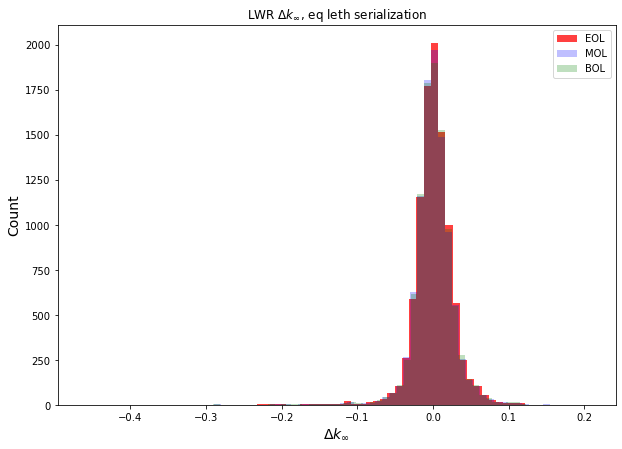

In [17]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=70,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=70,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=70,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, eq leth serialization")
plt.legend(loc='upper right')
plt.savefig("PICS/SFR_completeData_eqleth_boxlog_raytune_relu_wide.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
# Show plot
plt.show()


In [18]:
print(np.std(X_test[:,0]))
print(np.std(a[:,0]))
print(np.std(X_test[:,1]))
print(np.std(a[:,1]))
print(np.std(X_test[:,2]))
print(np.std(a[:,2]))

0.16186506663871794
0.036416457500692126
0.16571913677010885
0.03687024270129258
0.16685606944661246
0.03746634616229854


In [19]:
print(y_predicted[:,0])
print(y_predicted.shape)
print(y_test.shape)


[1.9424855 1.9422452 1.9515618 ... 1.9201685 1.8779131 1.9130841]
(9999, 3)
(3, 9999)


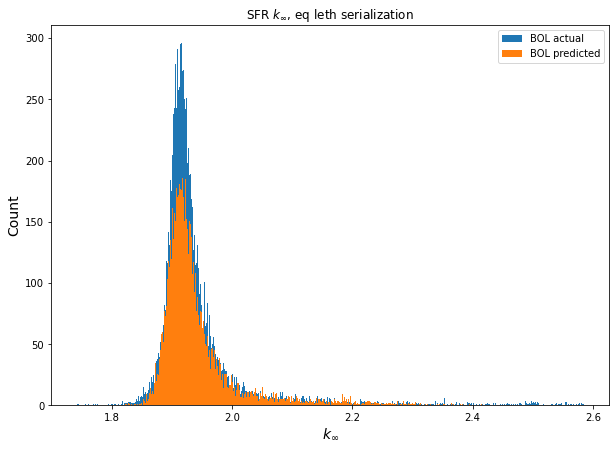

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL actual")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("SFR $k_{\infty}$, eq leth serialization")
plt.savefig("kinfPredDist_boxlog_raytune_relu_wide.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot

